## Dependencies

In [131]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 

## Settings

In [701]:
rows = 5
cols = 5
angular_width = math.pi/4
nnd=2
STD = .1

## Circle x Grid Functions

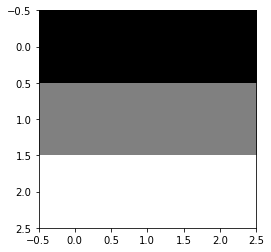

In [677]:
def t_from_N(N):
    angles = list(np.arange(0,(2*math.pi - (2*math.pi/N)),2*math.pi/N))
    len(angles)
    return angles

def circle_distance(x,y,theta):
    return x*math.cos(theta)/2 + y*math.sin(theta)/2

def generate_weights(theta, grid):
    grid_copy = copy.copy(grid)
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            grid_copy[i,j]=circle_distance(i,j,theta)*item
    return grid_copy

def normalize(grid):
    grid = grid - np.mean(grid)
    rsize = grid.shape
    grid = preprocessing.normalize(np.array([grid.flatten()]), norm='l2', axis=1, copy=True, return_norm=False).reshape(rsize)
    return(grid)

circle_number = 65
grid = np.ones([rows,cols])
circle_grids = [generate_weights(theta, grid) for theta in t_from_N(circle_number)]
circle_grids = [rows*STD*normalize(grid) for grid in circle_grids]

for g in circle_grids:
    plt.imshow(g, cmap="gray")
    plt.show()
    break


## Angular+grid-distance convolutional structure functions

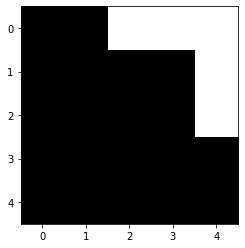

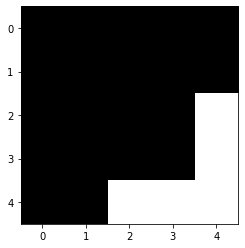

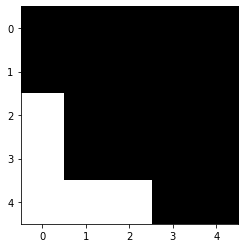

In [704]:
# center = math.floor(rows/2),math.floor(cols/2) # Floor because of 0-Index

# def angle_between(p1, p2):
#     ang1 = np.arctan2(*p1[::-1])
#     ang2 = np.arctan2(*p2[::-1])
#     return (ang1 - ang2) % (2 * np.pi)

# def define_grid_angles_onCircle(grid, center):
#     for i, row in enumerate(grid):
#         for j, item in enumerate(row):
#             coord = np.subtract((i,j),center)
#             coord[0]=-coord[0]
#             grid[i,j] = angle_between(coord, (0,0))
#     return grid

# def define_l2_distance(grid, center):
#     for i, row in enumerate(grid):
#         for j, item in enumerate(row):
#             coord = np.absolute(np.subtract((i,j),center))
#             grid[i,j] = max(coord)
#     return grid

# def define_circle_intervals(angular_width):
#     intervals=np.arange(0,2*math.pi,angular_width*2)
#     return intervals

# def define_angle_grid_memberships(grid, intervals, distance_grid):
#     perimeter_grid = distance_grid==np.max(distance_grid)
#     convolutional_membership_grids = []
#     for x, end in enumerate(intervals[1:]):
#         start = intervals[x]
#         grid_copy = np.zeros(grid.shape)
#         for i, row in enumerate(grid):
#             for j, item in enumerate(row):
#                 if(item>=start and item<=end and perimeter_grid[i,j]):
#                     grid_copy[i,j] = 1
#                 else:
#                     if(item==0 and end==2*math.pi):
#                         grid_copy[i,j] = 1
#         convolutional_membership_grids.append(grid_copy) ######## MAKE SURE TO REMOVE THIS CONDITION #########
#     return convolutional_membership_grids

# distance_grid = define_l2_distance(np.zeros([rows,cols]), center)
# angle_grid = define_grid_angles_onCircle(np.zeros([rows,cols]), center)           
# intervals = define_circle_intervals(angular_width)
# convolutional_membership_grids = define_angle_grid_memberships(angle_grid, intervals, distance_grid)

# for a in convolutional_membership_grids:
#     plt.imshow(a, cmap="gray")
#     plt.show()

## NN Implementation with overlap

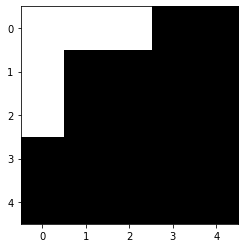

In [817]:
def define_l2_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.absolute(np.subtract((i,j),center))
            grid[i,j] = max(coord)
    return grid

def define_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.subtract((i,j),center)            
            grid[i,j] = np.sqrt(np.sum(np.square(coord)))
    return grid

center = math.floor(rows/2),math.floor(cols/2) # Floor because of 0-Index
distance_grid = define_l2_distance(np.zeros([rows,cols]), center)
perimeter_grid = distance_grid==np.max(distance_grid)

convolutional_membership_grids = []
for i, row in enumerate(perimeter_grid):
    for j, item in enumerate(row):
        if(item):
            grid_copy= ((define_distance(np.zeros([rows,cols]), (i,j))<=nnd)*1)*perimeter_grid
            convolutional_membership_grids.append(grid_copy)
        
for g in convolutional_membership_grids:
    plt.imshow(g, cmap='gray')
    plt.show()
    break

## Dependencies to run CNN

In [51]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import random

## Settings for CNNs

In [78]:
device = device = torch.device("cuda:0")
download = False
datadir = '/home/ephy/Projects/tda_convolution/data/'

## Load MNIST prepared for PyTorch

In [79]:
train = datasets.MNIST(datadir+"original/", train=True, download=download, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=True, download=download, 
                      transform= transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for data in trainset:
            X, y = data
            X=X.to(device)   
            y=y.to(device)   
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    return round(correct/total, 3)

## One Convolutional Layer

In [344]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

In [111]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        results.append(test(net))

In [112]:
results

[0.668, 0.9, 0.954, 0.961, 0.964, 0.955]

In [345]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

with torch.no_grad():
        for i,x in enumerate(circle_grids):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(circle_grids[i])).to(device)

circle_results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        circle_results.append(test(net))

In [346]:
circle_results

[0.39, 0.726, 0.81, 0.851, 0.858, 0.854]

In [109]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/primary_circle_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]
with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)

rick_circle_results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        rick_circle_results.append(test(net))

In [110]:
rick_circle_results

[0.811, 0.879, 0.943, 0.945, 0.958, 0.963]

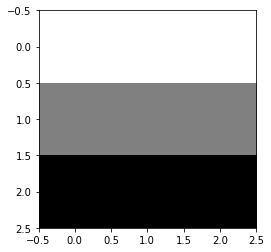

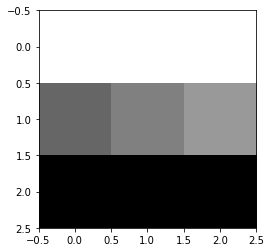

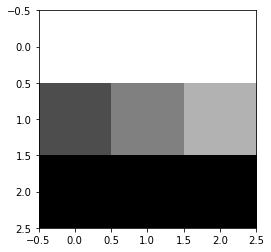

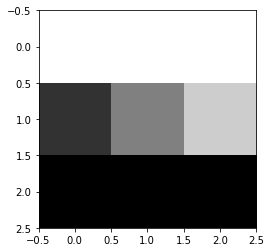

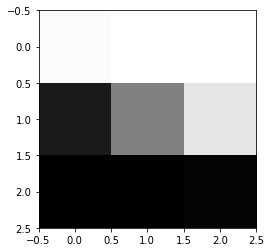

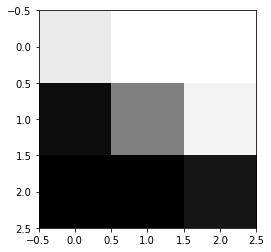

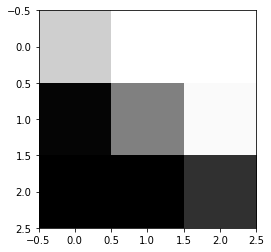

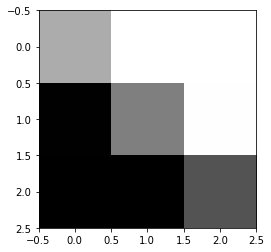

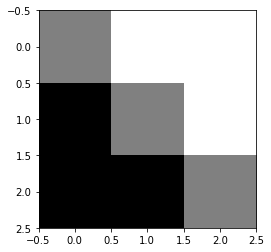

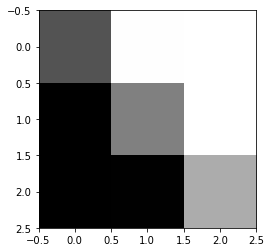

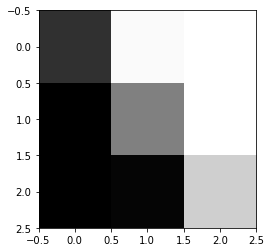

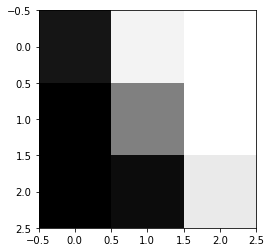

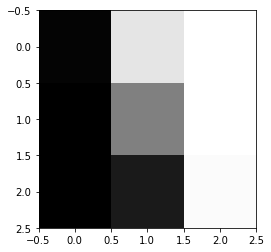

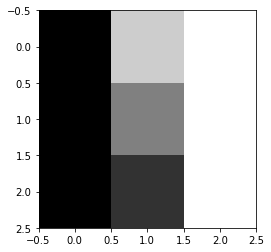

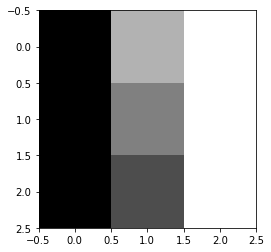

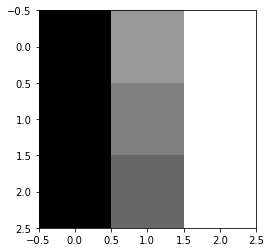

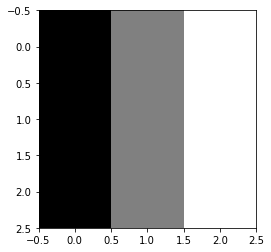

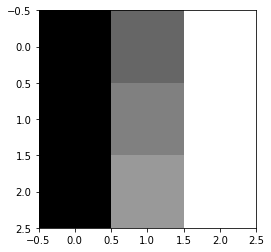

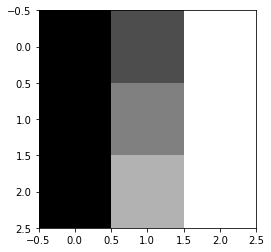

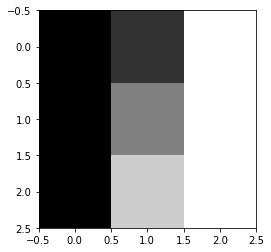

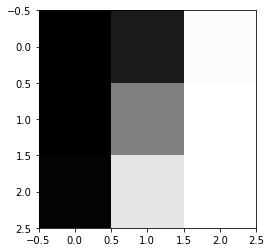

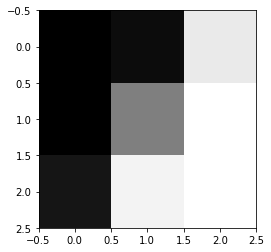

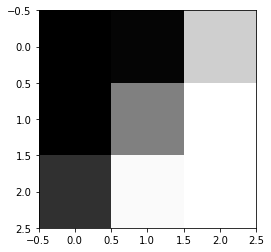

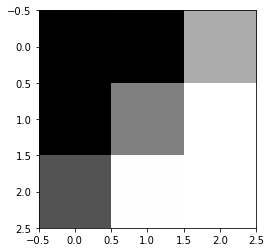

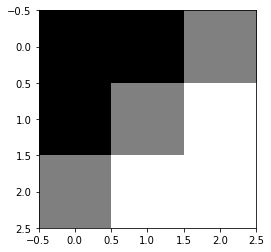

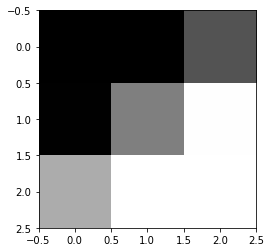

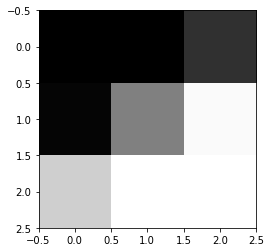

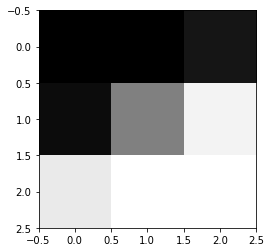

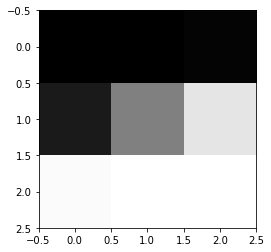

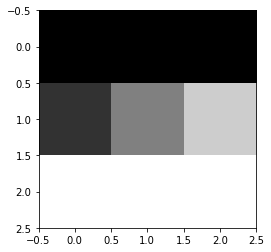

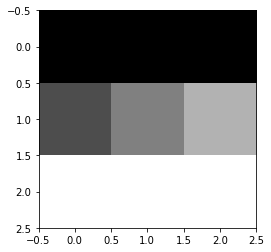

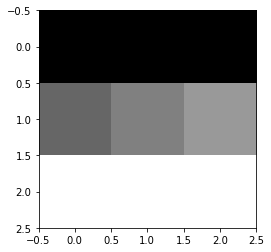

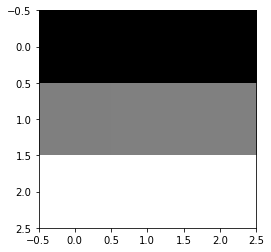

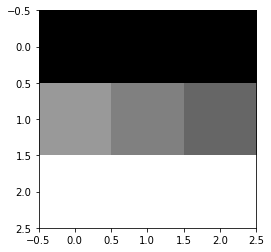

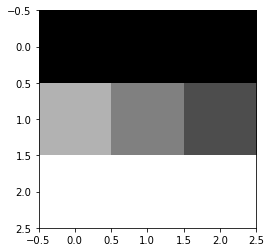

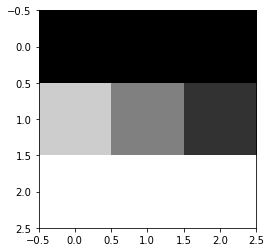

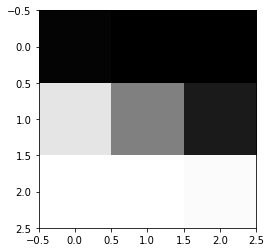

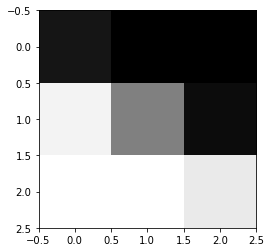

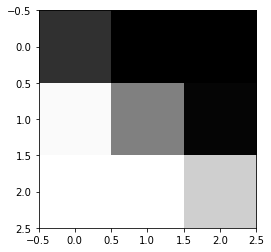

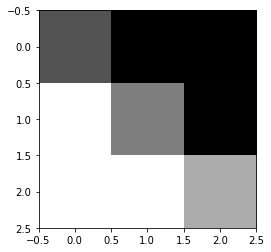

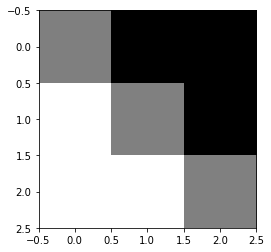

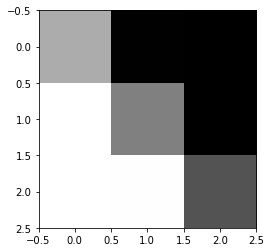

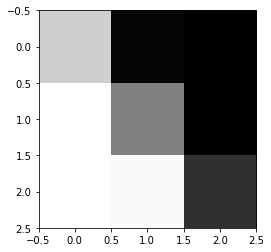

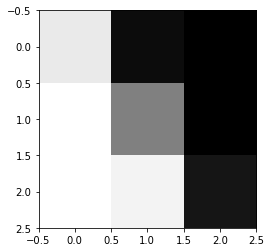

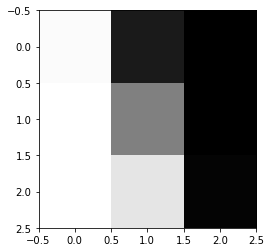

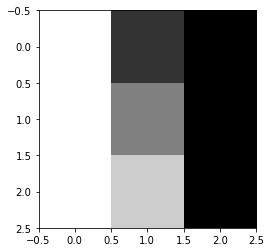

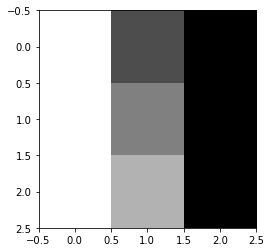

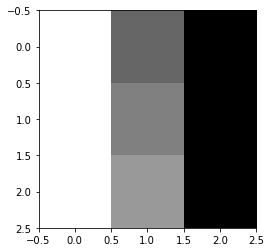

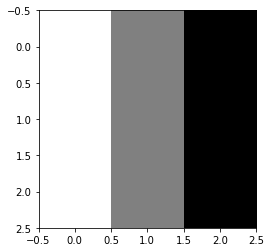

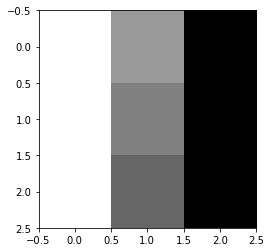

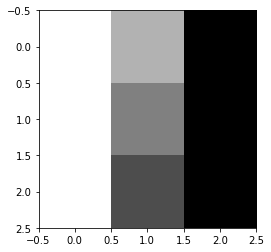

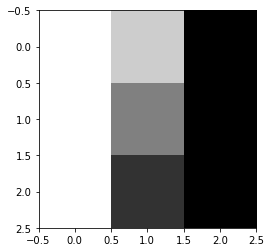

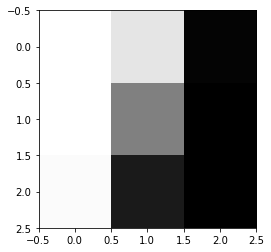

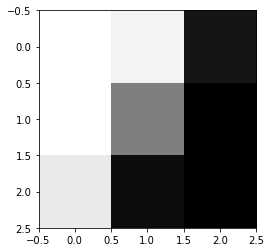

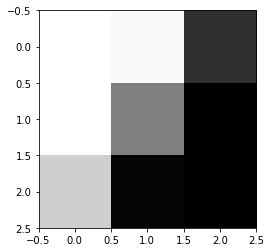

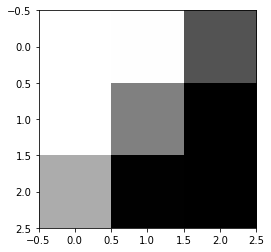

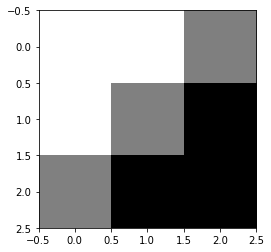

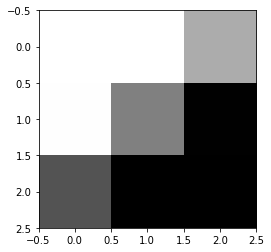

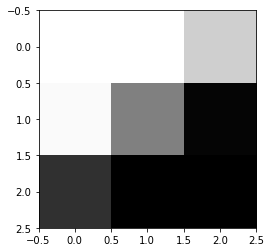

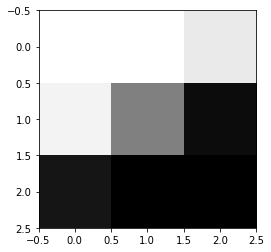

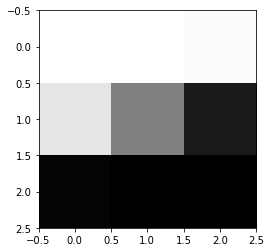

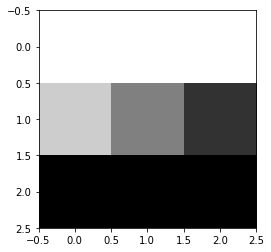

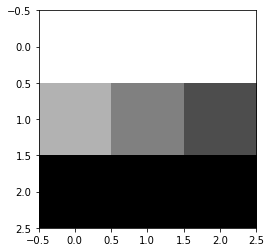

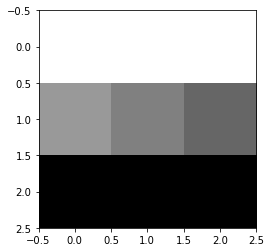

In [128]:
for i,x in enumerate(test_weights):
    plt.imshow(x, cmap='gray')
    plt.show()

## Frozen first layer to create continuous circle-features

In [172]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/primary_circle_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]
with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        # Freeze this layer
        for param in net.conv1.parameters():
            param.requires_grad = False
            

rick_frozen_circle_results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        rick_frozen_circle_results.append(test(net))

In [173]:
rick_frozen_circle_results

[0.714, 0.745, 0.712, 0.712, 0.718, 0.722]

## Convolutional Structure

In [209]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/primary_circle_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]
with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        # Freeze this layer
        for param in net.conv1.parameters():
            param.requires_grad = False
            

rick_frozen_circle_results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        rick_frozen_circle_results.append(test(net))

15

## Dependencies to produce circle filters

In [ ]:
from scipy.integrate import quad
import sklearn

## Code to produce circle filters

In [390]:
def integrand(x, k_y, r, m):
    return max( min( r*(x-(m/2.0)) + m/2.0, k_y + 1), k_y ) - k_y

def rotate(matrix, degree):
    degree = int(degree)
    if abs(degree) not in [0, 90, 180, 270, 360]:
        print("ERROR")
        assert(False)
    if degree == 0:
        return matrix
    elif degree > 0:
        return rotate(zip(*matrix[::-1]), degree-90)
    else:
        return rotate(zip(*matrix)[::-1], degree+90)

def primary_circle_weights(m, prim_circle_num):
    tot_angle=2*math.pi
    STD = .1
    list_weights = []
    for w in range(0, int(prim_circle_num)):
        M = np.zeros([int(m), int(m)])
        w = float(w)
        theta = w * (tot_angle) / prim_circle_num
        r = math.sin(theta) / math.cos(theta)

        for x_i in range(0, int(m)):
            for y_i in range(0, int(m)):
                I = quad(integrand, x_i, x_i+1, args=(y_i, r, m))
                sign = np.sign(r)
                if sign == 0: sign = 1
                A = sign * I[0]
                M[y_i, x_i] = A

        if theta > math.pi:
            M = list(rotate(list(rotate(M,90)), 90))
        
        M = np.array(M).flatten()
        M = M - np.mean(M)
        M = sklearn.preprocessing.normalize(np.array([M]), norm='l2', axis=1, copy=True, return_norm=False)[0]
        list_weights.append(M)

    Weights = np.array(list_weights)
    assert round(sum(Weights[0, :]) - 0, 3) == 0
    assert round(np.linalg.norm(Weights[0, :])- 1,3) == 0

    Weights = float(m) * float(STD) * Weights
    assert round(np.std(Weights[0, :])- STD,3) == 0
    assert round(np.std(Weights)- STD,3) == 0
    return Weights

In [616]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]
with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        # Freeze this layer
        for param in net.conv1.parameters():
            param.requires_grad = False
            

rick_frozen_circle_results=[]
for i, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((i+1)%1000)==0):
        rick_frozen_circle_results.append(test(net))

KeyboardInterrupt: 

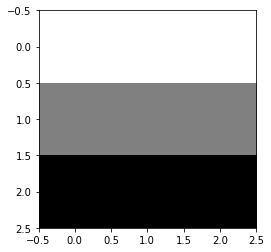

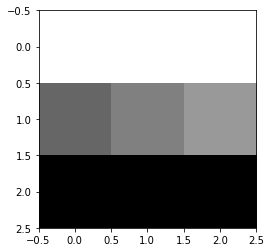

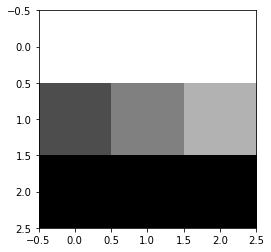

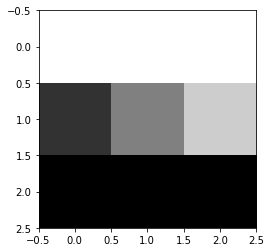

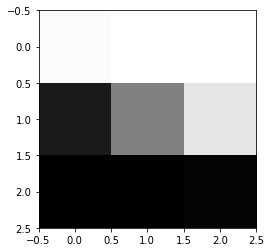

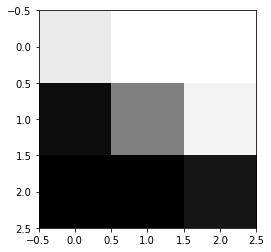

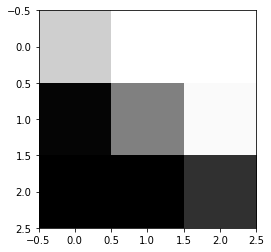

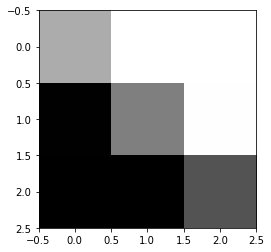

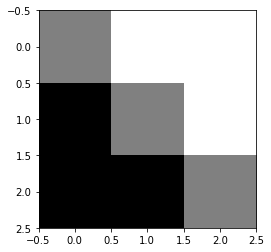

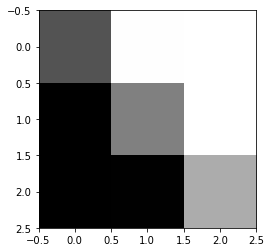

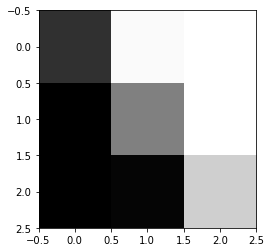

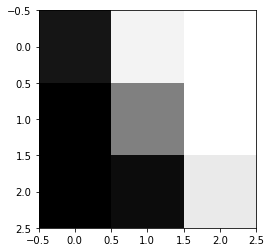

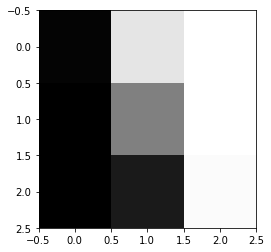

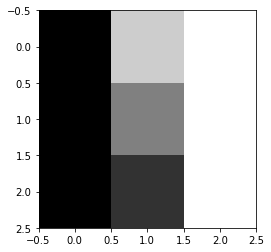

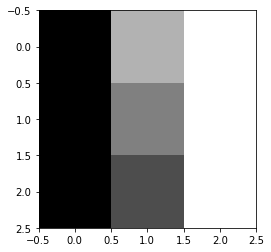

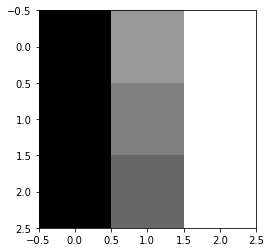

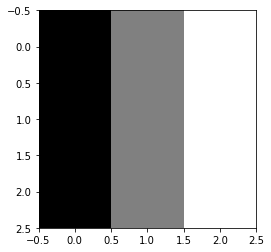

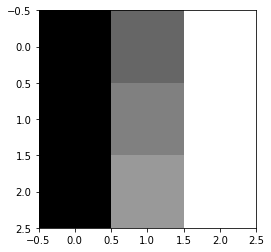

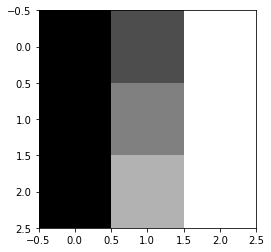

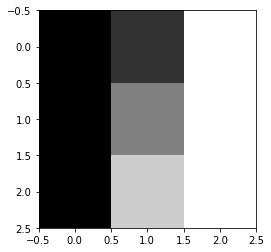

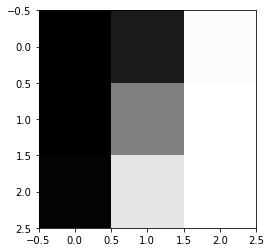

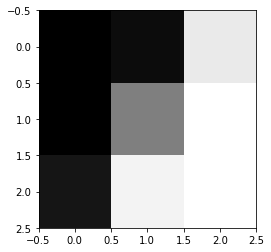

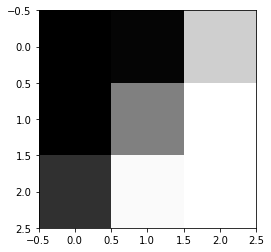

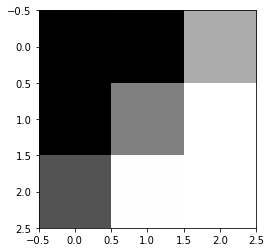

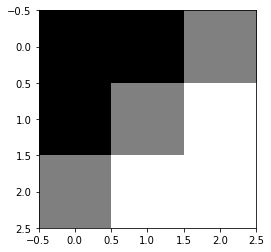

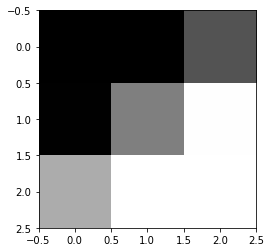

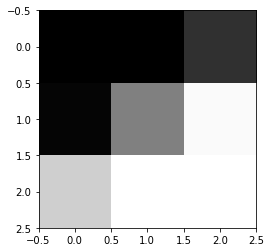

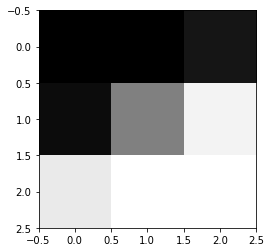

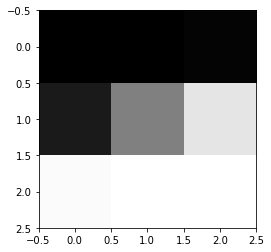

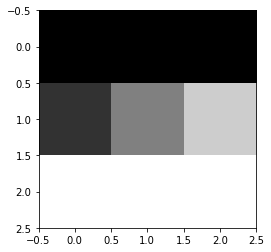

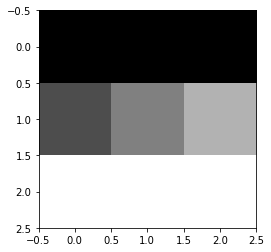

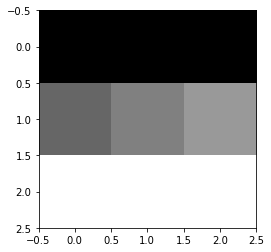

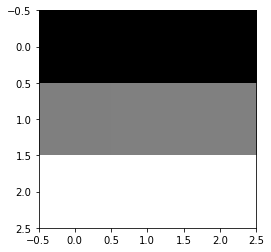

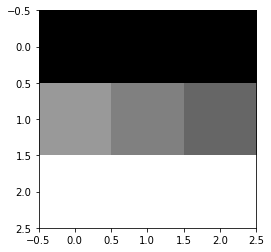

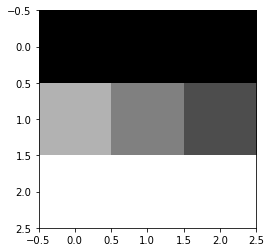

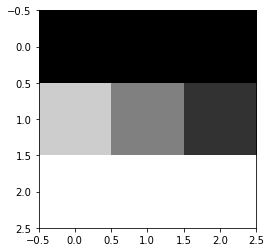

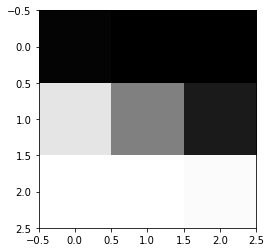

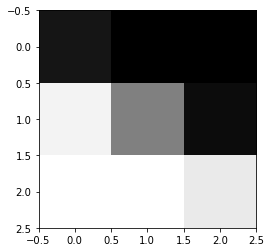

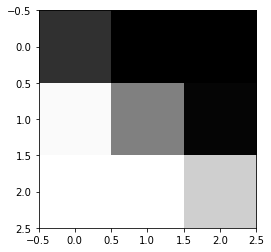

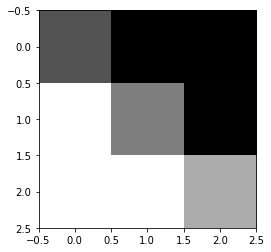

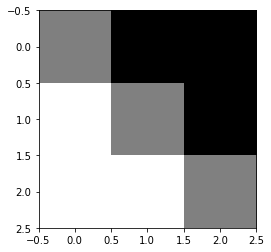

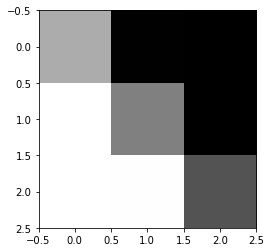

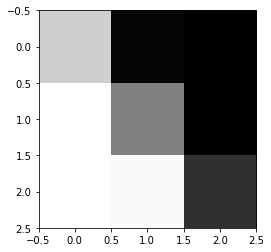

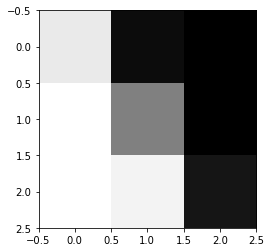

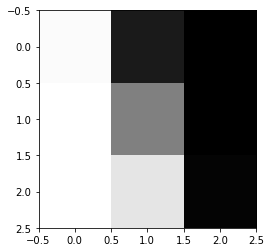

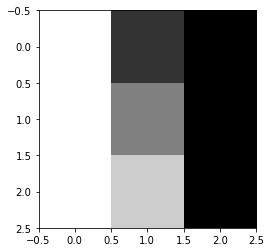

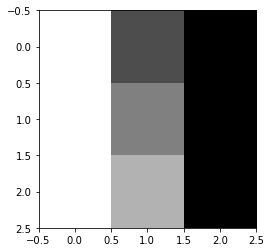

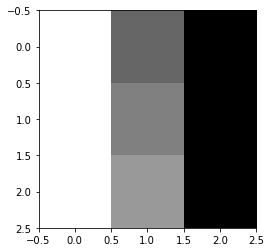

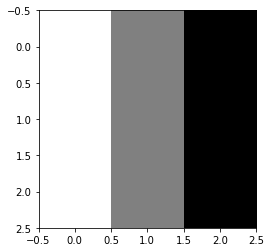

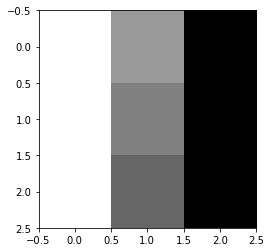

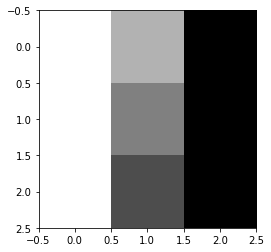

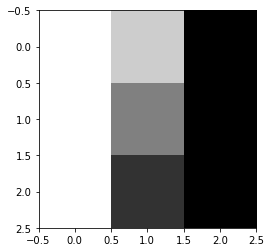

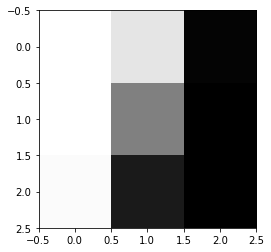

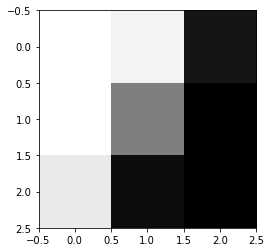

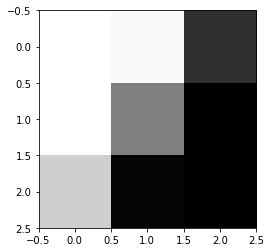

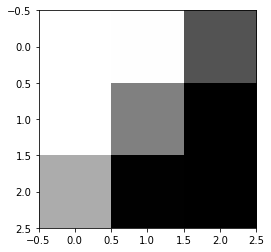

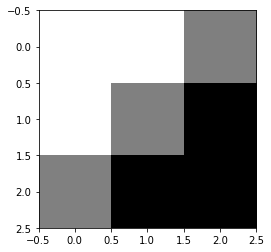

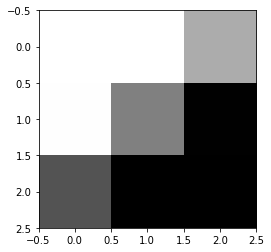

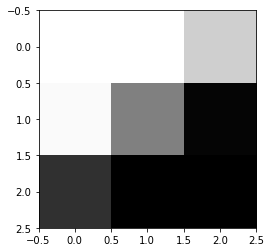

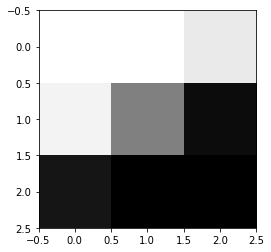

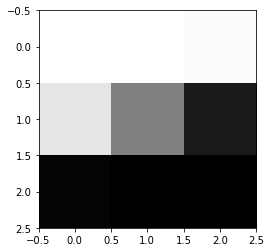

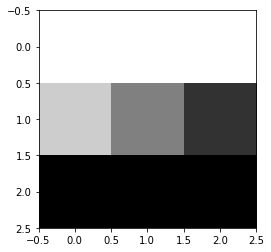

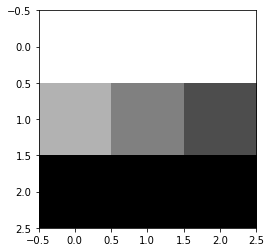

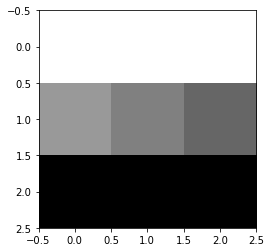

In [391]:
test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]
for p in test_weights:
    plt.imshow(p, cmap='gray')
    plt.show()

## Effectively remove connections to off-angle pixels

In [919]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
#optimizer = optim.SGD(net.parameters(), lr=1e-3)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy
#         # Freeze first layer
#         for param in net.conv1.parameters():
#             param.requires_grad = False

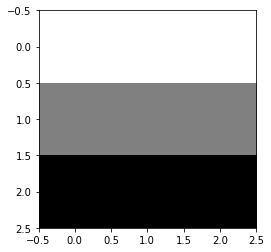

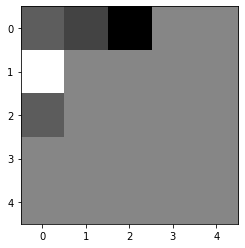

In [917]:
with torch.no_grad():
        for i,x in enumerate(net.conv1.weight):
            plt.imshow(np.array(net.conv1.weight[i].cpu()).reshape(3,3), cmap='gray')
            plt.show()
            break
        for i,x in enumerate(net.conv2.weight):
            plt.imshow(np.array(net.conv2.weight[i][0].cpu()).reshape(5,5), cmap='gray')
            plt.show()
            break

In [920]:
full_conv_results=[]
for n, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    
    # Check that this is working right
    
    with torch.no_grad():
        for x,param in enumerate(net.conv2.parameters()):
            if(x==0):
                for i in list(range(param.grad.shape[0])):
                    grad_m = param.grad[i,:,:,:]
                    weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                    param.grad[i,:,:,:] = grad_m*weights_m
    optimizer.step()
    if(((n+1)%100)==0):
        full_conv_results.append(test(net))

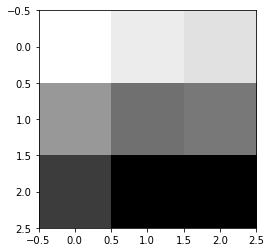

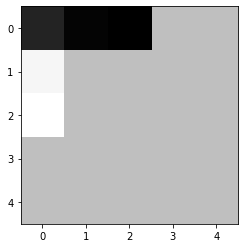

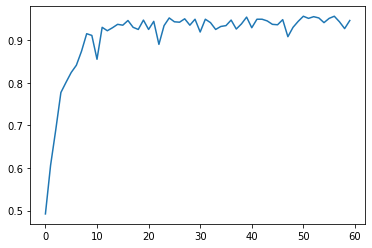

In [926]:
with torch.no_grad():
        for i,x in enumerate(net.conv1.weight):
            plt.imshow(np.array(net.conv1.weight[i].cpu()).reshape(3,3), cmap='gray')
            plt.show()
            break
        for i,x in enumerate(net.conv2.weight):
            plt.imshow(np.array(net.conv2.weight[i][0].cpu()).reshape(5,5), cmap='gray')
            plt.show()
            break

In [929]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [930]:
results=[]
for n, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((n+1)%100)==0):
        results.append(test(net))

In [934]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
            
circle_results=[]
for n, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((n+1)%100)==0):
        circle_results.append(test(net))

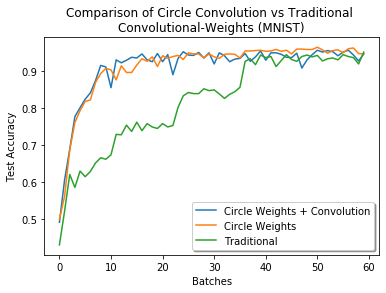

In [935]:
plt.plot(full_conv_results, label='Circle Weights + Convolution')
plt.plot(circle_results, label='Circle Weights')
plt.plot(results, label='Traditional')
plt.ylabel('Test Accuracy')
plt.xlabel('Batches')
plt.title('Comparison of Circle Convolution vs Traditional \nConvolutional-Weights (MNIST)')
legend = plt.legend(loc='lower right', shadow=True)

In [941]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
            
legendre_results=[]
for n, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()    
    optimizer.step()
    if(((n+1)%100)==0):
        legendre_results.append(test(net))

In [1132]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy
            
legendre_circConv_results=[]
for n, data in enumerate(trainset):
    X, y = data
    X=X.to(device)   
    y=y.to(device)   
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()    
    with torch.no_grad():
        for x,param in enumerate(net.conv2.parameters()):
            if(x==0):
                for i in list(range(param.grad.shape[0])):
                    grad_m = param.grad[i,:,:,:]
                    weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                    param.grad[i,:,:,:] = grad_m*weights_m
    optimizer.step()
    if(((n+1)%100)==0):
        legendre_circConv_results.append(test(net))

<class 'numpy.int64'>


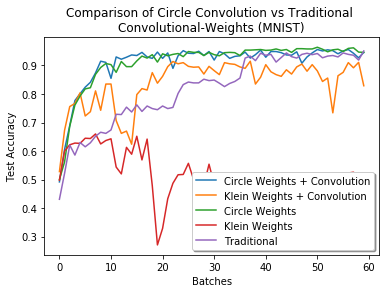

In [943]:
plt.plot(full_conv_results, label='Circle Weights + Convolution')
plt.plot(legendre_circConv_results, label='Klein Weights + Convolution')
plt.plot(circle_results, label='Circle Weights')
plt.plot(legendre_results, label='Klein Weights')
plt.plot(results, label='Traditional')
plt.ylabel('Test Accuracy')
plt.xlabel('Batches')
plt.title('Comparison of Circle Convolution vs Traditional \nConvolutional-Weights (MNIST)')
legend = plt.legend(loc='lower right', shadow=True)

In [1220]:
from mlxtend import data
XTRAIN, yTRAIN = data.loadlocal_mnist(
        images_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/train-images-idx3-ubyte', 
        labels_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/train-labels-idx1-ubyte')
XTEST, yTEST = data.loadlocal_mnist(
        images_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/t10k-images-idx3-ubyte', 
        labels_path='/home/ephy/Projects/tda_convolution/data/original/fashionmnist/t10k-labels-idx1-ubyte')

XTRAIN = [X.reshape(28,28) for X in XTRAIN]
XTRAIN = [X/255 for X in XTRAIN] # Mean center and normalize
#XTRAIN = [(X-np.mean(X))/np.std(X) for X in XTRAIN] # Mean center and normalize
XTEST = [X.reshape(28,28) for X in XTEST]
XTEST = [X/255 for X in XTEST] # Mean center and normalize
#XTEST = [(X-np.mean(X))/np.std(X) for X in XTEST] # Mean center and normalize

# Training examples already have uniform PMF
nclasses=len(set(yTRAIN))

In [1221]:
# Form into batches of 10
batch_size=10
seq = list(range(0,len(XTRAIN)+1,batch_size))
XTRAIN=[XTRAIN[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
yTRAIN=[yTRAIN[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
seq = list(range(0,len(XTEST)+1,batch_size))
XTEST=[XTEST[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
yTEST=[yTEST[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]

In [1222]:
def test_fashion(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for n, data in enumerate(XTEST):
            X = torch.tensor(data).to(device, dtype=torch.float).view(10, 1, 28, 28)
            y = torch.tensor(yTEST[n]).to(device, dtype=torch.long)
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    return round(correct/total, 3)

In [1223]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, nclasses)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

In [1224]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
            
fashion_circle_results=[]
for n, data in enumerate(XTRAIN):
    X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 28, 28)
    y = torch.tensor(yTRAIN[n]).to(device, dtype=torch.long)
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((n+1)%100)==0):
        fashion_circle_results.append(test_fashion(net))

In [1231]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

fashion_results=[]
for n, data in enumerate(XTRAIN):
    X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 28, 28)
    y = torch.tensor(yTRAIN[n]).to(device, dtype=torch.long)
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if(((n+1)%100)==0):
        fashion_results.append(test_fashion(net))

In [1226]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy
            
fashion_results_circleConv=[]
for n, data in enumerate(XTRAIN):
    X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 28, 28)
    y = torch.tensor(yTRAIN[n]).to(device, dtype=torch.long)
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    with torch.no_grad():
        for x,param in enumerate(net.conv2.parameters()):
            if(x==0):
                for i in list(range(param.grad.shape[0])):
                    grad_m = param.grad[i,:,:,:]
                    weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                    param.grad[i,:,:,:] = grad_m*weights_m
    optimizer.step()
    if(((n+1)%100)==0):
        fashion_results_circleConv.append(test_fashion(net))

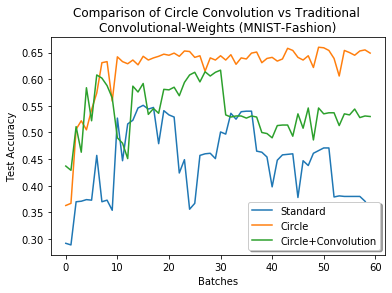

In [1234]:
plt.plot(fashion_results, label='Standard')
plt.plot(fashion_circle_results, label='Circle')
plt.plot(fashion_results_circleConv, label='Circle+Convolution')
plt.ylabel('Test Accuracy')
plt.xlabel('Batches')
plt.title('Comparison of Circle Convolution vs Traditional \nConvolutional-Weights (MNIST-Fashion)')
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [1233]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)

convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, len(convolutional_membership_grids_copied), 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 784)
        self.fc2 = nn.Linear(784, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy
            
fashion_results_klein_circleConv=[]
for n, data in enumerate(XTRAIN):
    X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 28, 28)
    y = torch.tensor(yTRAIN[n]).to(device, dtype=torch.long)
    net.zero_grad()
    output = net(X)
    loss = F.nll_loss(output, y)
    loss.backward()
    with torch.no_grad():
        for x,param in enumerate(net.conv2.parameters()):
            if(x==0):
                for i in list(range(param.grad.shape[0])):
                    grad_m = param.grad[i,:,:,:]
                    weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                    param.grad[i,:,:,:] = grad_m*weights_m
    optimizer.step()
    if(((n+1)%100)==0):
        fashion_results_klein_circleConv.append(test_fashion(net))

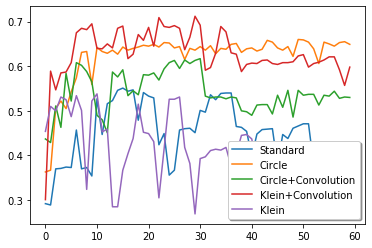

In [1232]:
plt.plot(fashion_results, label='Standard')
plt.plot(fashion_circle_results, label='Circle')
plt.plot(fashion_results_circleConv, label='Circle+Convolution')
plt.plot(fashion_results_klein_circleConv, label='Klein+Convolution')
plt.plot(fashion_results_klein, label='Klein')
legend = plt.legend(loc='lower right', shadow=True)

plt.show()

In [1235]:
torch.cuda.empty_cache()